In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
#export
from exp.nb_06 import *

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [4]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [5]:
nfs = [8,16,32,64,64]

In [6]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [7]:
%time run.fit(2, learn)

train: [1.30908734375, tensor(0.5746, device='cuda:0')]
valid: [0.2037240234375, tensor(0.9411, device='cuda:0')]
train: [0.19788220703125, tensor(0.9377, device='cuda:0')]
valid: [0.1336530517578125, tensor(0.9584, device='cuda:0')]
CPU times: user 6.73 s, sys: 1.77 s, total: 8.5 s
Wall time: 17.5 s


In [13]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars', torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [14]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [21]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn(l, f)
        
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)
    
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [22]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.28413974609375, tensor(0.9125, device='cuda:0')]
valid: [0.15558126220703125, tensor(0.9537, device='cuda:0')]


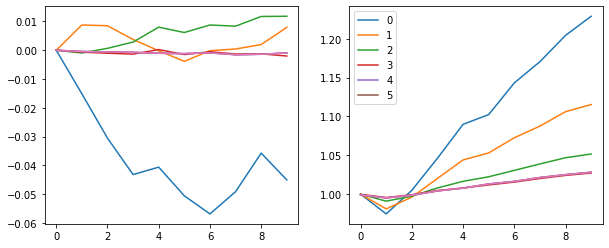

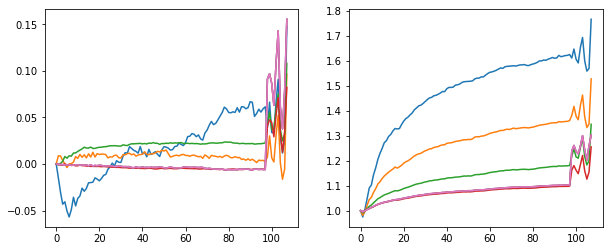

In [23]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [24]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [25]:
%time run.fit(3, learn)

train: [0.254600078125, tensor(0.9193, device='cuda:0')]
valid: [0.16705283203125, tensor(0.9479, device='cuda:0')]
train: [0.08291291015625, tensor(0.9741, device='cuda:0')]
valid: [0.0961976806640625, tensor(0.9714, device='cuda:0')]
train: [0.0619253857421875, tensor(0.9805, device='cuda:0')]
valid: [0.0830603759765625, tensor(0.9767, device='cuda:0')]
CPU times: user 2.91 s, sys: 626 ms, total: 3.53 s
Wall time: 2.94 s


In [26]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
             GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [27]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [28]:
%time run.fit(3, learn)

train: [0.221866796875, tensor(0.9292, device='cuda:0')]
valid: [0.08478690185546875, tensor(0.9726, device='cuda:0')]
train: [0.066024462890625, tensor(0.9795, device='cuda:0')]
valid: [0.07050830078125, tensor(0.9790, device='cuda:0')]
train: [0.042716318359375, tensor(0.9869, device='cuda:0')]
valid: [0.069113623046875, tensor(0.9792, device='cuda:0')]
CPU times: user 2.64 s, sys: 640 ms, total: 3.28 s
Wall time: 2.75 s


In [29]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [31]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [32]:
run.fit(8, learn)

train: [0.26239353515625, tensor(0.9199, device='cuda:0')]
valid: [0.1207505126953125, tensor(0.9631, device='cuda:0')]
train: [0.08479697265625, tensor(0.9738, device='cuda:0')]
valid: [0.119644091796875, tensor(0.9627, device='cuda:0')]
train: [0.0608545947265625, tensor(0.9808, device='cuda:0')]
valid: [0.0658861572265625, tensor(0.9812, device='cuda:0')]
train: [0.03680844482421875, tensor(0.9879, device='cuda:0')]
valid: [0.06361444702148437, tensor(0.9817, device='cuda:0')]
train: [0.02186759765625, tensor(0.9934, device='cuda:0')]
valid: [0.04672164611816406, tensor(0.9858, device='cuda:0')]
train: [0.01322310546875, tensor(0.9961, device='cuda:0')]
valid: [0.04439656982421875, tensor(0.9868, device='cuda:0')]
train: [0.007917748413085937, tensor(0.9982, device='cuda:0')]
valid: [0.04300977783203125, tensor(0.9876, device='cuda:0')]
train: [0.005097692260742187, tensor(0.9993, device='cuda:0')]
valid: [0.04143134765625, tensor(0.9883, device='cuda:0')]


In [33]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [34]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [35]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [36]:
%time run.fit(3, learn)

train: [nan, tensor(0.1725, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.23 s, sys: 794 ms, total: 4.03 s
Wall time: 3.45 s


In [37]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [38]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [39]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [40]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.33 s, sys: 655 ms, total: 3.98 s
Wall time: 3.39 s


### Fix small batch sizes

In [41]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [42]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [43]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [44]:
%time run.fit(1, learn)

train: [2.32334109375, tensor(0.1938, device='cuda:0')]
valid: [2.6278185546875, tensor(0.3098, device='cuda:0')]
CPU times: user 47.1 s, sys: 493 ms, total: 47.6 s
Wall time: 48.6 s


### Running Batch Norm

In [57]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps=mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))
        
    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims=(0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        self.mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.sums.lerp_ (s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [58]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [59]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [60]:
%time run.fit(1, learn)

train: [0.3998254296875, tensor(0.8986, device='cuda:0')]
valid: [0.1636154052734375, tensor(0.9616, device='cuda:0')]
CPU times: user 1min 51s, sys: 812 ms, total: 1min 51s
Wall time: 1min 53s


In [61]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [62]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [63]:
%time run.fit(1, learn)

train: [0.154321015625, tensor(0.9523, device='cuda:0')]
valid: [0.07797676391601563, tensor(0.9783, device='cuda:0')]
CPU times: user 7.48 s, sys: 167 ms, total: 7.65 s
Wall time: 7.48 s


In [ ]:
nb_auto_export()